In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [13]:
torch.manual_seed(7)

In [14]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=64, shuffle=True)

C:\Users\ianey\AppData\Local\Temp\ipykernel_16504\2182951934.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
C:\Users\ianey\AppData\Local\Temp\ipykernel_16504\2182951934.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [15]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=64, shuffle=True)

C:\Users\ianey\AppData\Local\Temp\ipykernel_16504\2331197148.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
C:\Users\ianey\AppData\Local\Temp\ipykernel_16504\2331197148.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [16]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    diff = (torch.sum(torch.abs(inl.weight.data - ninc)).item(), torch.sum(torch.abs(oul.weight.data-noul)).item())

    inl.weight.data = ninc
    oul.weight.data = noul

    return diff


In [17]:
model = model.to('cuda')
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

num_epochs = 20  
for epoch in range(num_epochs):
    for b in tqdm(trainloader):
        xt, y = b[0].to('cuda'), b[1].to('cuda')
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
    
    for i in range(len(lay)):
        if i > 0 and i <= len(lay)-1:
            di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])
            while(di[0]+di[1] > .001):
                di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

    for i in range(len(lay)):
        print(f'layer l2 norm for layer {i} = {torch.linalg.norm(lay[i][1].weight, ord=2)}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0].to('cuda'), i[1].to('cuda')
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')


Linear
Linear
Linear
Linear


100%|██████████| 938/938 [00:02<00:00, 350.81it/s]


Epoch 0/20, Loss: 0.015362049452960491
layer l2 norm for layer 0 = 12.582353591918945
layer l2 norm for layer 1 = 7.929424285888672
layer l2 norm for layer 2 = 3.0548555850982666
layer l2 norm for layer 3 = 2.5199458599090576
test dataset accuracy: 92.31%


100%|██████████| 938/938 [00:02<00:00, 372.68it/s]


Epoch 1/20, Loss: 0.013726762495934963
layer l2 norm for layer 0 = 11.080541610717773
layer l2 norm for layer 1 = 8.860000610351562
layer l2 norm for layer 2 = 4.843550205230713
layer l2 norm for layer 3 = 3.3523447513580322
test dataset accuracy: 93.66%


100%|██████████| 938/938 [00:02<00:00, 377.45it/s]


Epoch 2/20, Loss: 0.006951797753572464
layer l2 norm for layer 0 = 9.958905220031738
layer l2 norm for layer 1 = 9.74459171295166
layer l2 norm for layer 2 = 6.093531608581543
layer l2 norm for layer 3 = 4.104314804077148
test dataset accuracy: 93.37%


100%|██████████| 938/938 [00:02<00:00, 383.20it/s]


Epoch 3/20, Loss: 0.018345190212130547
layer l2 norm for layer 0 = 9.899931907653809
layer l2 norm for layer 1 = 11.112936019897461
layer l2 norm for layer 2 = 7.264734268188477
layer l2 norm for layer 3 = 4.912639617919922
test dataset accuracy: 93.13%


100%|██████████| 938/938 [00:02<00:00, 390.75it/s]


Epoch 4/20, Loss: 0.01629502885043621
layer l2 norm for layer 0 = 9.90605640411377
layer l2 norm for layer 1 = 12.393426895141602
layer l2 norm for layer 2 = 8.414978981018066
layer l2 norm for layer 3 = 5.638349533081055
test dataset accuracy: 93.61%


100%|██████████| 938/938 [00:02<00:00, 400.53it/s]


Epoch 5/20, Loss: 0.004242999944835901
layer l2 norm for layer 0 = 10.343287467956543
layer l2 norm for layer 1 = 13.826985359191895
layer l2 norm for layer 2 = 9.670937538146973
layer l2 norm for layer 3 = 6.398399829864502
test dataset accuracy: 92.69%


100%|██████████| 938/938 [00:02<00:00, 390.84it/s]


Epoch 6/20, Loss: 0.010783246718347073
layer l2 norm for layer 0 = 10.763282775878906
layer l2 norm for layer 1 = 15.431371688842773
layer l2 norm for layer 2 = 10.928851127624512
layer l2 norm for layer 3 = 7.193081855773926
test dataset accuracy: 93.86%


100%|██████████| 938/938 [00:02<00:00, 413.08it/s]


Epoch 7/20, Loss: 0.01330472994595766
layer l2 norm for layer 0 = 10.966621398925781
layer l2 norm for layer 1 = 16.923587799072266
layer l2 norm for layer 2 = 12.146939277648926
layer l2 norm for layer 3 = 8.00401782989502
test dataset accuracy: 93.59%


100%|██████████| 938/938 [00:02<00:00, 384.70it/s]


Epoch 8/20, Loss: 0.007073111832141876
layer l2 norm for layer 0 = 11.625178337097168
layer l2 norm for layer 1 = 18.261322021484375
layer l2 norm for layer 2 = 13.430611610412598
layer l2 norm for layer 3 = 8.858292579650879
test dataset accuracy: 93.42%


100%|██████████| 938/938 [00:02<00:00, 366.02it/s]


Epoch 9/20, Loss: 0.007666930556297302
layer l2 norm for layer 0 = 12.020995140075684
layer l2 norm for layer 1 = 19.711666107177734
layer l2 norm for layer 2 = 14.73843765258789
layer l2 norm for layer 3 = 9.78758716583252
test dataset accuracy: 93.65%


100%|██████████| 938/938 [00:02<00:00, 367.12it/s]


Epoch 10/20, Loss: 0.016503268852829933
layer l2 norm for layer 0 = 12.36593246459961
layer l2 norm for layer 1 = 21.133785247802734
layer l2 norm for layer 2 = 16.054574966430664
layer l2 norm for layer 3 = 10.681770324707031
test dataset accuracy: 93.8%


100%|██████████| 938/938 [00:02<00:00, 381.33it/s]


Epoch 11/20, Loss: 0.005615508183836937
layer l2 norm for layer 0 = 12.896066665649414
layer l2 norm for layer 1 = 22.677532196044922
layer l2 norm for layer 2 = 17.35692596435547
layer l2 norm for layer 3 = 11.456865310668945
test dataset accuracy: 93.86%


100%|██████████| 938/938 [00:02<00:00, 385.47it/s]


Epoch 12/20, Loss: 0.010583274066448212
layer l2 norm for layer 0 = 13.421417236328125
layer l2 norm for layer 1 = 24.147903442382812
layer l2 norm for layer 2 = 18.642465591430664
layer l2 norm for layer 3 = 12.314473152160645
test dataset accuracy: 93.5%


100%|██████████| 938/938 [00:02<00:00, 378.40it/s]


Epoch 13/20, Loss: 0.011765243485569954
layer l2 norm for layer 0 = 14.484370231628418
layer l2 norm for layer 1 = 25.59626579284668
layer l2 norm for layer 2 = 19.903413772583008
layer l2 norm for layer 3 = 13.18177318572998
test dataset accuracy: 93.59%


100%|██████████| 938/938 [00:02<00:00, 368.67it/s]


Epoch 14/20, Loss: 0.011170560494065285
layer l2 norm for layer 0 = 15.433886528015137
layer l2 norm for layer 1 = 27.174341201782227
layer l2 norm for layer 2 = 21.18360137939453
layer l2 norm for layer 3 = 14.05303955078125
test dataset accuracy: 93.76%


100%|██████████| 938/938 [00:02<00:00, 382.98it/s]


Epoch 15/20, Loss: 0.01630428247153759
layer l2 norm for layer 0 = 15.757925033569336
layer l2 norm for layer 1 = 28.58696937561035
layer l2 norm for layer 2 = 22.373674392700195
layer l2 norm for layer 3 = 14.87804889678955
test dataset accuracy: 93.22%


100%|██████████| 938/938 [00:02<00:00, 372.38it/s]


Epoch 16/20, Loss: 0.0058086952194571495
layer l2 norm for layer 0 = 16.66291618347168
layer l2 norm for layer 1 = 30.129961013793945
layer l2 norm for layer 2 = 23.634151458740234
layer l2 norm for layer 3 = 15.638934135437012
test dataset accuracy: 93.19%


100%|██████████| 938/938 [00:02<00:00, 361.60it/s]


Epoch 17/20, Loss: 0.0014128078473731875
layer l2 norm for layer 0 = 17.309066772460938
layer l2 norm for layer 1 = 31.488374710083008
layer l2 norm for layer 2 = 24.808218002319336
layer l2 norm for layer 3 = 16.4852352142334
test dataset accuracy: 93.55%


100%|██████████| 938/938 [00:02<00:00, 361.00it/s]


Epoch 18/20, Loss: 0.005865688435733318
layer l2 norm for layer 0 = 17.6846923828125
layer l2 norm for layer 1 = 32.82070541381836
layer l2 norm for layer 2 = 26.00911521911621
layer l2 norm for layer 3 = 17.303451538085938
test dataset accuracy: 93.29%


100%|██████████| 938/938 [00:02<00:00, 376.80it/s]


Epoch 19/20, Loss: 0.007503093685954809
layer l2 norm for layer 0 = 18.828907012939453
layer l2 norm for layer 1 = 34.12453842163086
layer l2 norm for layer 2 = 27.19308090209961
layer l2 norm for layer 3 = 18.094764709472656
test dataset accuracy: 93.92%


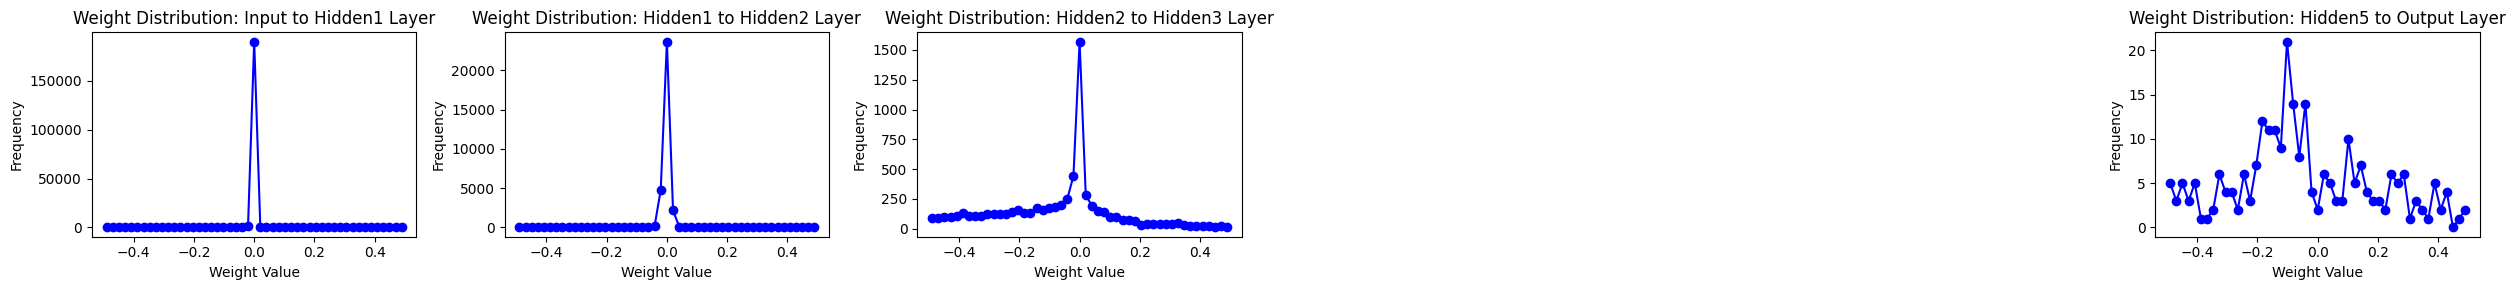

In [18]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
fc3_weights = model.fc3.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
fc3_hist, fc3_bins = np.histogram(fc3_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
fc3_bin_centers = 0.5 * (fc3_bins[:-1] + fc3_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 3))

plt.subplot(1, 6, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden1 to Hidden2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 3)
plt.plot(fc3_bin_centers, fc3_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden2 to Hidden3 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 6)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden5 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [19]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.1):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.fc3, threshold=threshold_value)
nonzero_out = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1} = {100*nonzero_fc1/(model.fc.weight.data.shape[0]*model.fc.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2} = {100*nonzero_fc2/(model.fc2.weight.data.shape[0]*model.fc2.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3} = {100*nonzero_fc3/(model.fc3.weight.data.shape[0]*model.fc3.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_out} = {100*nonzero_out/(model.out.weight.data.shape[0]*model.out.weight.data.shape[1])}%')

Number of non-zero weights greater than 0.01 in layer 1: 10956 = 5.458785076530612%
Number of non-zero weights greater than 0.01 in layer 1: 9448 = 28.8330078125%
Number of non-zero weights greater than 0.01 in layer 3: 6636 = 81.005859375%
Number of non-zero weights greater than 0.01 in layer 1: 638 = 99.6875%


In [20]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.9289213720951033, 0.9164554254500694, 0.9168685347136319, 0.918896922113054, 0.9316957000914919, 0.9327710774447241, 0.9119914656196831, 0.9144480246577474, 0.9357079411218117, 0.9250221725383416, 0.9345204929014796, 0.937732436243812, 0.9174441960350358, 0.926362934999833, 0.9113472897940652, 0.920866627349429, 0.9213933938084545, 0.9141503357148631, 0.9140526357124273, 0.9354704856436825, 0.9120095450491347, 0.916171023604704, 0.9142294571847804, 0.9125115123539584, 0.9148723629807806, 0.9213627387662441, 0.9342157119978379, 0.9134582816189446, 0.9372350311060965, 0.925793744742923, 0.9240389060927875, 0.9140300254080997, 0.9139523579629567, 0.9120234060567204, 0.930646753575724, 0.9138242177853306, 0.9234632334939674, 0.9237895074165393, 0.9202497392635306, 0.9403482964904095, 0.9141185994742709, 0.9369538253653038, 0.9149695499287692, 0.9131700576573425, 0.9153251492270088, 0.9112005751440742, 0.9371899006799134, 0.9273130776487022, 0.9135708430093272, 0.9398010534134252, 0.9385